# 3. Algorithm Selection for Prediction

Till now, we have been successfully able to clean the raw files and calculate the sentiment of every review. Now we need to begin the most crutial part of selecting the right algorithm to support our predictions.

## Importing libraries and initial data prep

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import datetime as datetime
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn import metrics
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import cross_validation
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from ggplot import *

C:\Users\Kunal Seth\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Loading the restaurant review file containing all sentiment values
rest_sentiment_df = pd.read_csv('rest_review_sentiment.csv', index_col=0)

In [298]:
# Reviewing the file
print rest_sentiment_df.shape

(2577380, 10)


In [720]:
rest_sentiment_df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,Review_Sentiment
0,4P-vTvE6cncJyUyLh73pxw,0,2014-03-29,0,6-hKBi-6RC3g7Mft0c-6qw,4.0,This place is a area staple! Been around for y...,0.0,3.0
1,4P-vTvE6cncJyUyLh73pxw,0,2014-08-14,0,tRd0-mPa9O1TMJp_dw5khQ,4.0,Got my mojo back after having a few of their a...,0.0,0.0
2,4P-vTvE6cncJyUyLh73pxw,0,2012-10-20,0,8Mu56iQ-MYEyivqUVss0XA,4.0,"Don't go here for the decor, but the staff is ...",1.0,2.0
3,4P-vTvE6cncJyUyLh73pxw,1,2012-08-25,0,ToC77cIEiMas9CPU7dt_fA,5.0,I believe in awarding stars bearing in mind th...,2.0,1.0
4,4P-vTvE6cncJyUyLh73pxw,0,2015-07-27,0,6YC4o9yLc25DK8c6soOlaw,4.0,"If you like fried food and laid back, then thi...",0.0,2.0


In [299]:
# Dropping the unnamed column-- Run only once after loading
# rest_sentiment_df = rest_sentiment_df.drop(rest_sentiment_df.columns[0], axis=1)

## Adding last review dates

In [302]:
# Loading the restaurant_business
rest_business = pd.read_csv('restaurant_business.csv', index_col=0)

In [303]:
# Prep to Finding the last review date
review_date = rest_sentiment_df.copy()

In [732]:
# Grouping on the business id to find the max value for the date
review_date_grp = review_date.groupby('business_id').max().reset_index()

In [733]:
# Have a look at the shape- basically 1 row per restaurant with the last review dates
review_date_grp.shape

(48493, 9)

In [734]:
# Dropping the columns that not required and keeping only business id and last review date for a restaurant
review_date_grp = review_date_grp.ix[:,(0,2)]

In [735]:
# Data views
review_date_grp.head()

,business_id,date
0,--6MefnULPED_I942VcFNA,2016-12-10
1,--9e1ONYQuAa-CB_Rrw7Tw,2017-01-20
2,--DaPTJW3-tB1vP-PfdTEg,2017-01-08
3,--FBCX-N37CMYDfs790Bnw,2016-12-30
4,--GM_ORV2cYS-h38DSaCLw,2017-01-16


In [744]:
# Merging dataframes on restaurant sentiment and last review dates
max_review_super_df = pd.merge(rest_sentiment_df, review_date_grp, how="left", on="business_id")

In [745]:
# View Data
max_review_super_df.head()

,business_id,cool,date_x,funny,review_id,stars,text,useful,Review_Sentiment,date_y
0,4P-vTvE6cncJyUyLh73pxw,0,2014-03-29,0,6-hKBi-6RC3g7Mft0c-6qw,4.0,This place is a area staple! Been around for y...,0.0,3.0,2016-08-14
1,4P-vTvE6cncJyUyLh73pxw,0,2014-08-14,0,tRd0-mPa9O1TMJp_dw5khQ,4.0,Got my mojo back after having a few of their a...,0.0,0.0,2016-08-14
2,4P-vTvE6cncJyUyLh73pxw,0,2012-10-20,0,8Mu56iQ-MYEyivqUVss0XA,4.0,"Don't go here for the decor, but the staff is ...",1.0,2.0,2016-08-14
3,4P-vTvE6cncJyUyLh73pxw,1,2012-08-25,0,ToC77cIEiMas9CPU7dt_fA,5.0,I believe in awarding stars bearing in mind th...,2.0,1.0,2016-08-14
4,4P-vTvE6cncJyUyLh73pxw,0,2015-07-27,0,6YC4o9yLc25DK8c6soOlaw,4.0,"If you like fried food and laid back, then thi...",0.0,2.0,2016-08-14


In [748]:
# Calculating the days between the review date and the last review date to filter on a date range in the future
max_review_super_df['days_between'] = pd.to_datetime(max_review_super_df['date_y']) - pd.to_datetime(max_review_super_df['date_x'])

In [749]:
# Filtering the dataset to consider only the reviews in the last 1 year
max_review_super_df_365 = max_review_super_df[max_review_super_df['days_between']<np.timedelta64(datetime.timedelta(days=365))]

In [750]:
# View data
max_review_super_df_365.head()

,business_id,cool,date_x,funny,review_id,stars,text,useful,Review_Sentiment,date_y,days_between
7,4P-vTvE6cncJyUyLh73pxw,0,2015-09-05,0,4FnZR30PtlEb1Ifi7S65bg,3.0,Okay bar food. Nice bar setting but food is av...,0.0,3.000000,2016-08-14,344 days
10,4P-vTvE6cncJyUyLh73pxw,1,2016-05-11,0,FFTN8Y1U9G2F_p1dQnxO7A,4.0,"Okay, so it is a bar with an old fashioned fam...",0.0,2.500000,2016-08-14,95 days
11,4P-vTvE6cncJyUyLh73pxw,0,2016-05-04,0,VlDz03s9VyODcVi1S9-Yfw,3.0,3 stars is fair for this pub. \r\r\r\n\r\r\r\n...,0.0,2.666667,2016-08-14,102 days
12,4P-vTvE6cncJyUyLh73pxw,0,2016-01-23,0,HbnWR7vaXD5FLCcrrMAGhg,1.0,"Unmmmm, no. It's a bar with tables in the next...",0.0,1.500000,2016-08-14,204 days
13,4P-vTvE6cncJyUyLh73pxw,0,2016-03-17,0,YGfi1F_Fuc_OyemfqQFspg,1.0,Have dined in twice now and today was take out...,1.0,1.333333,2016-08-14,150 days


In [751]:
# Comparing shapes for the joins
print rest_business.shape
print len(max_review_super_df_365['business_id'].unique())

(48493, 8)
48493


## Calculating Number of positive and negative reviews

In [673]:
len(max_review_super_df_365[max_review_super_df_365['Review_Sentiment']<1])

244447

In [753]:
# Dropping the text columns since we are going to group down
max_review_super_df_365_grp = max_review_super_df_365.ix[:,(0,1,3,5,7,8)]

In [755]:
# max_review_super_df_365_grp

In [757]:
# Adding a new column to evaluate if the sentiment is positive using a threshold.
max_review_super_df_365_grp['Pos_sent'] = np.where(max_review_super_df_365_grp['Review_Sentiment']>1, 1,0)

C:\Users\Kunal Seth\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [758]:
# Adding a new column to evaluate if the sentiment is negative using a threshold.
max_review_super_df_365_grp['neg_sent'] = np.where(max_review_super_df_365_grp['Review_Sentiment']<1, 1,0)

C:\Users\Kunal Seth\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [759]:
# Adding a column for total sentiments
max_review_super_df_365_grp['total_sent'] = 1

C:\Users\Kunal Seth\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [761]:
# View Data
max_review_super_df_365_grp.head()

,business_id,cool,funny,stars,useful,Review_Sentiment,Pos_sent,neg_sent,total_sent
7,4P-vTvE6cncJyUyLh73pxw,0,0,3.0,0.0,3.000000,1,0,1
10,4P-vTvE6cncJyUyLh73pxw,1,0,4.0,0.0,2.500000,1,0,1
11,4P-vTvE6cncJyUyLh73pxw,0,0,3.0,0.0,2.666667,1,0,1
12,4P-vTvE6cncJyUyLh73pxw,0,0,1.0,0.0,1.500000,1,0,1
13,4P-vTvE6cncJyUyLh73pxw,0,0,1.0,1.0,1.333333,1,0,1


In [762]:
# Grouping by the business ids and aggregating values (summation)
max_review_super_df_365_grp2 = max_review_super_df_365_grp.groupby('business_id').sum().reset_index()

In [765]:
# View Data
max_review_super_df_365_grp2.head()

(48493, 9)

## Data merge for reviews and restaurants

In [775]:
# Merging the grouped review dataset to the resturant business dataframe
super_main_df1 = pd.merge(max_review_super_df_365_grp2, rest_business, how="inner", on="business_id")

In [783]:
super_main_df1

,business_id,cool,funny,stars_x,useful,Review_Sentiment,Pos_sent,neg_sent,total_sent,address,categories,city,is_open,name,review_count,stars_y
0,--6MefnULPED_I942VcFNA,3,3,16.0,5.0,5.600000,4,1,5,"328 Highway 7 E, Chalmers Gate 11, Unit 10","Chinese,Restaurants",Richmond Hill,1,John's Chinese BBQ Restaurant,24,3.0
1,--9e1ONYQuAa-CB_Rrw7Tw,125,81,653.0,166.0,265.933401,110,38,159,3355 Las Vegas Blvd S,"Steakhouses,Restaurants,Cajun/Creole",Las Vegas,1,Delmonico Steakhouse,1311,4.0
2,--DaPTJW3-tB1vP-PfdTEg,1,0,26.0,0.0,10.607143,4,1,7,1218 Saint Clair Avenue W,"Restaurants,Breakfast & Brunch",Toronto,1,Sunnyside Grill,32,3.5
3,--FBCX-N37CMYDfs790Bnw,8,6,74.0,13.0,46.266667,17,1,18,11624 Bermuda Rd,"American (New),Restaurants,Beer,Wine & Spirits...",Henderson,1,The Bar At Bermuda & St. Rose,88,4.0
4,--GM_ORV2cYS-h38DSaCLw,1,0,7.0,0.0,1.000000,0,1,2,407 S Central Ave,"Pizza,Restaurants,Chicken Wings,Salad",Canonsburg,1,Mm Mm Pizza,6,3.5
5,--I7YYLada0tSLkORTHb5Q,3,3,81.0,6.0,31.602381,12,11,25,9436 State Rte 14,"Restaurants,Nightlife,Sports Bars,Bars,America...",Streetsboro,1,Happy Moose Bar and Grill,49,3.5
6,--KCl2FvVQpvjzmZSPyviA,0,0,9.0,1.0,4.830769,2,2,4,"6426 W Sugar Creek Rd, Unit A","Pizza,Sandwiches,Restaurants",Charlotte,1,Hungry Howie's Pizza,10,2.5
7,--Ni3oJ4VOqfOEu7Sj2Vzg,0,0,6.0,3.0,1.666667,1,2,4,1245 Pearl Road,"Restaurants,Chicken Wings,Fast Food",Brunswick,1,KFC,4,1.5
8,--S62v0QgkqQaVUhFnNHrw,0,0,11.0,0.0,-2.666667,0,3,3,6207 Wilson Mills Rd,"American (Traditional),Restaurants,Breakfast &...",Highland Heights,1,Denny's,17,2.5
9,--SrzpvFLwP_YFwB_Cetow,6,1,30.0,7.0,6.344444,3,5,8,"3300 Midland Avenue, Unit 41","Restaurants,Chinese",Toronto,1,Keung Kee Restaurant,33,3.5


In [784]:
# Dropping address, categories, city and name columns
super_main_df = super_main_df1.ix[:, (0,1,2,3,4,5,6,7,8,12)]

In [785]:
# Calculating average stars for a restaurant
super_main_df['stars_x'] = super_main_df['stars_x']/super_main_df['total_sent']

C:\Users\Kunal Seth\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [786]:
# Calculating average sentiment for a restuarant
super_main_df['Avg_sent'] = (super_main_df['Review_Sentiment']/super_main_df['total_sent'])

C:\Users\Kunal Seth\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [787]:
# View Data
super_main_df.head()

,business_id,cool,funny,stars_x,useful,Review_Sentiment,Pos_sent,neg_sent,total_sent,is_open,Avg_sent
0,--6MefnULPED_I942VcFNA,3,3,3.200000,5.0,5.600000,4,1,5,1,1.120000
1,--9e1ONYQuAa-CB_Rrw7Tw,125,81,4.106918,166.0,265.933401,110,38,159,1,1.672537
2,--DaPTJW3-tB1vP-PfdTEg,1,0,3.714286,0.0,10.607143,4,1,7,1,1.515306
3,--FBCX-N37CMYDfs790Bnw,8,6,4.111111,13.0,46.266667,17,1,18,1,2.570370
4,--GM_ORV2cYS-h38DSaCLw,1,0,3.500000,0.0,1.000000,0,1,2,1,0.500000


In [370]:
# super_main_df.to_csv('super_main_df_3mts4.csv', sep=',')

## Data Splitting into Train and Test

In [794]:
# Creating a copy for working on the regression
yelp_df = super_main_df.copy()

In [795]:
# Filtering the restaurants to have greater than 5 reviews
yelp_df_filtered = yelp_df[yelp_df['total_sent']>5].reset_index(drop=True)

In [974]:
# Data View
# yelp_df_filtered

In [986]:
yelp_df_filtered = (yelp_df_filtered[~((yelp_df_filtered['is_open'] == 0) & (yelp_df_filtered['Avg_sent'] >1.5 ))]).reset_index(drop=True)

In [985]:
yelp_df_filtered

,business_id,cool,funny,stars_x,useful,Review_Sentiment,Pos_sent,neg_sent,total_sent,is_open,Avg_sent
0,--9e1ONYQuAa-CB_Rrw7Tw,125,81,4.106918,166.0,265.933401,110,38,159,1,1.672537
1,--DaPTJW3-tB1vP-PfdTEg,1,0,3.714286,0.0,10.607143,4,1,7,1,1.515306
2,--FBCX-N37CMYDfs790Bnw,8,6,4.111111,13.0,46.266667,17,1,18,1,2.570370
3,--I7YYLada0tSLkORTHb5Q,3,3,3.240000,6.0,31.602381,12,11,25,1,1.264095
4,--SrzpvFLwP_YFwB_Cetow,6,1,3.750000,7.0,6.344444,3,5,8,1,0.793056
5,--cZ6Hhc9F7VkKXxHMVZSQ,25,13,3.925926,44.0,70.184499,32,19,54,1,1.299713
7,--ujyvoQlwVoBgMYtADiLA,5,3,3.941176,9.0,32.832967,14,3,17,1,1.931351
8,-01XupAWZEXbdNbxNg5mEg,0,3,2.583333,11.0,12.152464,6,6,12,1,1.012705
9,-092wE7j5HZOogMLAh40zA,3,2,3.333333,7.0,22.026190,8,6,15,1,1.468413
10,-0NrB58jqKqJfuUCDupcsw,5,1,3.458333,16.0,36.502778,18,6,24,1,1.520949


In [987]:
# Creating a target dataframe using the target variable -is_open
yelp_df_target = (yelp_df_filtered['is_open']).astype('category')

In [988]:
# Dropping business id, is_open columns
yelp_df_variables = (yelp_df_filtered.ix[:,(1,2,3,4,5,6,7,8,10)])

In [989]:
# Dataframe to be used for logistic regression
# yelp_df_variables

In [990]:
# Using stratifiedshuffle to maintain ratio of 1/0 to avoid skewness
sss= StratifiedShuffleSplit(yelp_df_target, 1, test_size=0.2, random_state=121)

In [991]:
# Splitting datasets into train and test dataframes
for train_index, test_index in sss:
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = np.array(yelp_df_variables)[train_index], np.array(yelp_df_variables)[test_index]
    y_train, y_test = yelp_df_target[train_index], yelp_df_target[test_index]

('TRAIN:', array([ 2501, 20682, 22161, ..., 18830,  8885, 15647], dtype=int64), 'TEST:', array([11426, 12078,  1313, ..., 14390,  5920, 22205], dtype=int64))


## Random Forests for feature selection

In [992]:
# Running random forests to see feature importance
rf = RandomForestRegressor()
rf.fit(yelp_df_variables, yelp_df_target)
names = list(yelp_df_variables.columns.values)

print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.2558, 'Avg_sent'), (0.162, 'Review_Sentiment'), (0.1559, 'stars_x'), (0.098, 'useful'), (0.0816, 'cool'), (0.075, 'funny'), (0.0583, 'neg_sent'), (0.0571, 'total_sent'), (0.0563, 'Pos_sent')]


In [993]:
yelp_df_variables.head()

,cool,funny,stars_x,useful,Review_Sentiment,Pos_sent,neg_sent,total_sent,Avg_sent
0,125,81,4.106918,166.0,265.933401,110,38,159,1.672537
1,1,0,3.714286,0.0,10.607143,4,1,7,1.515306
2,8,6,4.111111,13.0,46.266667,17,1,18,2.570370
3,3,3,3.240000,6.0,31.602381,12,11,25,1.264095
4,6,1,3.750000,7.0,6.344444,3,5,8,0.793056


## Random Forests

In [994]:
# Specifying Random forest classifier
clf = RandomForestClassifier()

In [1133]:
# Fitting the Random forest model
clf.fit(X_train[:, (8,5,6,3,2,1)], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [1134]:
# Predicting on the test dataset
rf_predicted = clf.predict(X_test[:,(8,5,6,3,2,1)])

In [1135]:
# Confusion Matrix- Random Forest
pd.crosstab(y_test, rf_predicted, rownames=['Actual Value'], colnames=['Predicted Value'])

Predicted Value,0,1
Actual Value,,
0,136,559
1,280,3863


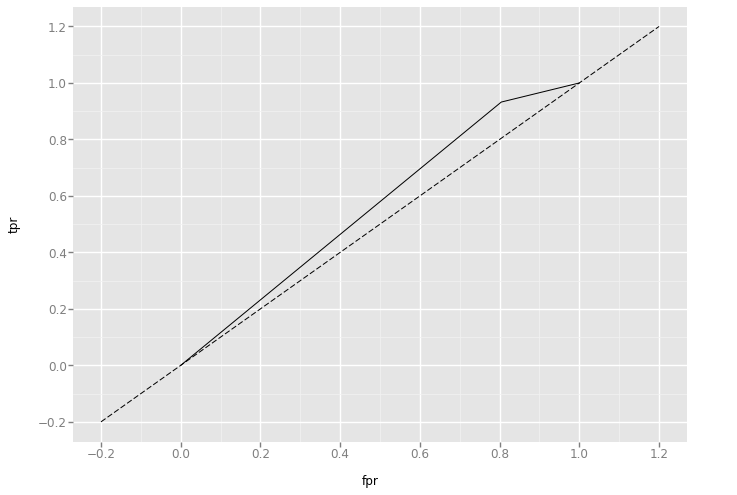

<ggplot: (351355312)>

In [1142]:
# ROC Curve Random Forests
fpr, tpr, _ = metrics.roc_curve(y_test, rf_predicted)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

## Logistic Regression

In [1136]:
# Logistic Regression on test train split using columns : 
logit = sm.Logit((y_train), X_train[:,(8,5,6,3,2,1)])

# fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.382212
         Iterations 8


In [1137]:
# Regression summary
print 'Regression Summary:'
print result.summary()
print '\nConfidence Interval:'
print result.conf_int()

Regression Summary:
                           Logit Regression Results                           
Dep. Variable:                is_open   No. Observations:                19348
Model:                          Logit   Df Residuals:                    19342
Method:                           MLE   Df Model:                            5
Date:                Sun, 30 Apr 2017   Pseudo R-squ.:                 0.07118
Time:                        23:48:53   Log-Likelihood:                -7395.0
converged:                       True   LL-Null:                       -7961.8
                                        LLR p-value:                7.714e-243
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0816      0.053      1.533      0.125        -0.023     0.186
x2             0.0591      0.004     14.964      0.000         0.051     0.067
x3             0.0001      0.004

In [1138]:
# Predicting using the test set
y_pred = result.predict(X_test[:,(8,5,6,3,2,1)])
print 'Predicted Probabilities:' + str(y_pred)
# print y

Predicted Probabilities:[ 0.7562277   0.8456512   0.64120341 ...,  0.89224688  0.97979201
  0.89380075]


In [1139]:
# Converting the probabilities greater than 0.5 to predict 1 and below 0.5 to predict 0
y_pred1 = np.where(y_pred > 0.5, 1, 0)
print y_pred1

[1 1 1 ..., 1 1 1]


In [1140]:
print 'Classification Report:'
print(metrics.classification_report(y_test, y_pred1))
print '\nConfusion Matrix:'
print(metrics.confusion_matrix(y_test, y_pred1))

Classification Report:
             precision    recall  f1-score   support

          0       0.40      0.00      0.01       695
          1       0.86      1.00      0.92      4143

avg / total       0.79      0.86      0.79      4838


Confusion Matrix:
[[   2  693]
 [   3 4140]]


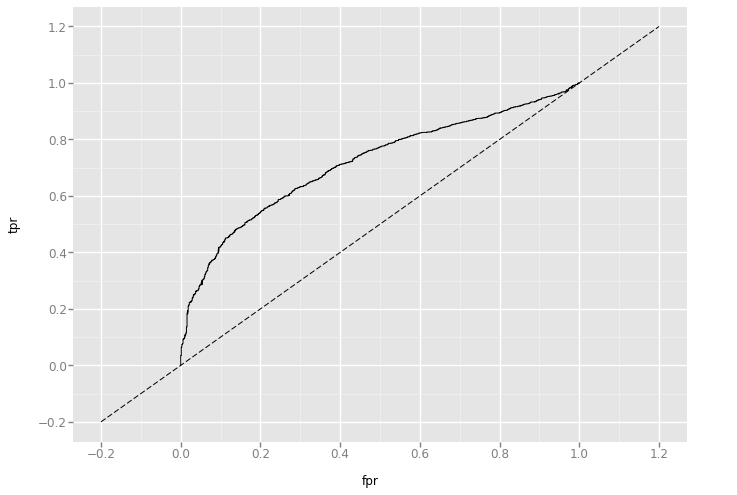

<ggplot: (269176328)>

In [1141]:
# ROC Curve- Logistic Regression
fpr1, tpr1, _ = metrics.roc_curve(y_test, y_pred)

df = pd.DataFrame(dict(fpr=fpr1, tpr=tpr1))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')